Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 990  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 820         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007990815 |
|    clip_fraction        | 0.0454      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | -0.675      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0217     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00841    |
|    std                

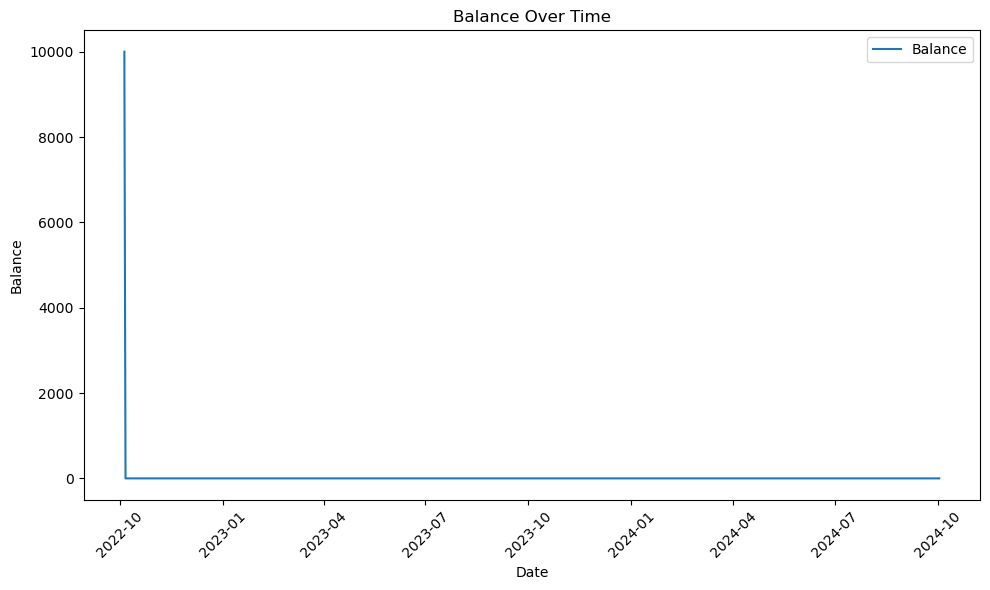

AttributeError: 'ForexTradingEnv' object has no attribute 'net_worth_history'

<Figure size 1000x600 with 0 Axes>

In [13]:
# ================================
# 1. IMPORTING LIBRARIES
# ================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import ta
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# =================================
# 2. LOADING AND PREPROCESSING DATA
# =================================

# Load data
df = pd.read_csv(r'C:\Users\Daniel\Documents\Trading\Trading Bot\EURUSD-H1-2Years.csv', delimiter='\t')
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Vol', 'Spread']

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ensure 'Time' is in datetime.time format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Combine 'Date' and 'Time' into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Feature Engineering: Extracting Hour and Minute, Cyclical Encoding
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Minute'] = df['Time'].apply(lambda x: x.minute)

# Cyclical encoding for Hour (0-23)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# Cyclical encoding for Minute (0-59)
df['Minute_sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute_cos'] = np.cos(2 * np.pi * df['Minute'] / 60)

# Dropping unnecessary columns
df.drop(['Hour', 'Minute', 'Vol', 'Time', 'Minute_sin', 'Minute_cos'], axis=1, inplace=True)

# ================================
# 3. ADDING TECHNICAL INDICATORS
# ================================

# 1. Simple Moving Averages (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
df['SMA_50'] = ta.trend.SMAIndicator(close=df['Close'], window=50).sma_indicator()

# 2. Exponential Moving Averages (EMA)
df['EMA_12'] = ta.trend.EMAIndicator(close=df['Close'], window=12).ema_indicator()
df['EMA_26'] = ta.trend.EMAIndicator(close=df['Close'], window=26).ema_indicator()

# 3. Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

# 4. MACD (Moving Average Convergence Divergence)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Diff'] = macd.macd_diff()

# 5. Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()
df['Bollinger_Middle'] = bollinger.bollinger_mavg()

# 6. Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

# 7. On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['TickVol']).on_balance_volume()

# 8. Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], window1=9, window2=26, window3=52)
df['Ichimoku_A'] = ichimoku.ichimoku_a()
df['Ichimoku_B'] = ichimoku.ichimoku_b()

# 9. Commodity Channel Index (CCI)
df['CCI'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20).cci()

# 10. Volume-Weighted Average Price (VWAP)
df['VWAP'] = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Close'], volume=df['TickVol']).volume_weighted_average_price()

# ================================
# 4. HANDLING MISSING VALUES
# ================================

# Forward fill to handle NaNs
df = df.ffill()
# Drop remaining NaN rows
df = df.dropna().reset_index(drop=True)

# =====================================
# 5. COMBINING ALL FEATURES AND SCALING
# =====================================

class ForexTradingEnv(gym.Env):
    """
    A custom OpenAI Gym environment for Forex trading using reinforcement learning.
    """
    def __init__(self, df):
        super(ForexTradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)  # Ensure the DataFrame index is sequential
        self.total_steps = len(self.df)

        # Initial account balance and settings
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.equity = self.initial_balance
        self.margin = 0
        self.free_margin = self.initial_balance
        self.margin_level = 0
        self.leverage = 100  # 1:100 leverage

        # Position details
        self.position = 0  # -1: short, 0: no position, 1: long
        self.position_size = 0  # In lots
        self.entry_price = 0
        self.stop_loss_price = 0
        self.take_profit_price = 0
        self.lot_size = 100000  # Standard lot size in currency units

        # For tracking history
        self.balance_history = []
        self.equity_history = []
        self.profit_history = []
        self.position_history = []
        self.trade_log = []  # For detailed logging

        # Select only numerical columns for observation
        self.numeric_columns = self.df.select_dtypes(include=[np.number]).columns.tolist()

        # Define action and observation space
        # Action space: [action_type (discrete as continuous), stop_loss, take_profit]
        self.action_space = spaces.Box(low=np.array([0, 0.0001, 0.0001]), high=np.array([3, 0.01, 0.01]), dtype=np.float32)

        # Observation space: all numerical features
        num_features = len(self.numeric_columns)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(num_features,), dtype=np.float32)

    def reset(self, *, seed=None, options=None):
        """
        Reset the state of the environment to an initial state.
        """
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.equity = self.initial_balance
        self.margin = 0
        self.free_margin = self.initial_balance
        self.margin_level = 0
        self.position = 0
        self.position_size = 0
        self.entry_price = 0
        self.stop_loss_price = 0
        self.take_profit_price = 0

        # Reset history
        self.balance_history = [self.balance]
        self.equity_history = [self.equity]
        self.profit_history = [0]
        self.position_history = [self.position]
        self.trade_log = []

        return self._next_observation(), {}

    def _next_observation(self):
        """
        Get the observation for the current step.
        """
        # Extract the current row
        obs = self.df.loc[self.current_step, self.numeric_columns].values.astype(np.float32)

        # Replace any NaNs with zeros to ensure stability
        obs = np.nan_to_num(obs, nan=0.0, posinf=0.0, neginf=0.0)

        return obs

    def _calculate_margin(self, position_size, price):
        """
        Calculate the required margin for a position.
        """
        # Margin = (Contract Size * Lot Size) / Leverage
        margin = (position_size * self.lot_size) / self.leverage
        return margin

    def _update_account_info(self, current_price):
        """
        Update equity, margin, free margin, and margin level.
        """
        if self.position != 0:
            # Unrealized profit/loss
            if self.position == 1:
                profit = (current_price - self.entry_price) * self.position_size * self.lot_size
            else:
                profit = (self.entry_price - current_price) * self.position_size * self.lot_size

            self.margin = self._calculate_margin(self.position_size, current_price)
            self.equity = self.balance + profit
            self.free_margin = self.equity - self.margin
            self.margin_level = (self.equity / self.margin) * 100 if self.margin > 0 else 0
        else:
            self.margin = 0
            self.equity = self.balance
            self.free_margin = self.balance
            self.margin_level = 0

    def step(self, action):
        """
        Execute one time step within the environment.
        """
        # Initialize the terminated and truncated flags
        terminated = False
        truncated = False

        # Current price and spread
        current_price = self.df.loc[self.current_step, 'Close']
        spread = self.df.loc[self.current_step, 'Spread']

        # Adjust prices for spread
        ask_price = current_price + (spread / 2)
        bid_price = current_price - (spread / 2)

        # Unpack action: the first value is the action type, the second and third are stop_loss and take_profit
        action_type = int(action[0])
        stop_loss = action[1]
        take_profit = action[2]

        # Execute action
        if action_type == 1 and self.position == 0:  # Open Long position
            max_position_size = (self.free_margin * self.leverage) / self.lot_size
            self.position_size = max_position_size  # Use all available margin
            self.entry_price = ask_price  # Buy at ask price
            self.position = 1
            self.margin = self._calculate_margin(self.position_size, self.entry_price)
            self.stop_loss_price = self.entry_price - stop_loss
            self.take_profit_price = self.entry_price + take_profit

        elif action_type == 2 and self.position == 0:  # Open Short position
            max_position_size = (self.free_margin * self.leverage) / self.lot_size
            self.position_size = max_position_size  # Use all available margin
            self.entry_price = bid_price  # Sell at bid price
            self.position = -1
            self.margin = self._calculate_margin(self.position_size, self.entry_price)
            self.stop_loss_price = self.entry_price + stop_loss
            self.take_profit_price = self.entry_price - take_profit

        elif action_type == 3 and self.position != 0:  # Close position
            if self.position == 1:
                profit = (bid_price - self.entry_price) * self.position_size * self.lot_size
            else:
                profit = (self.entry_price - ask_price) * self.position_size * self.lot_size
            self.balance += profit
            self.position = 0
            self.position_size = 0
            self.entry_price = 0
            self.stop_loss_price = 0
            self.take_profit_price = 0
            self.margin = 0

        # Check for stop-loss or take-profit hit
        if self.position != 0:
            if self.position == 1:
                if bid_price <= self.stop_loss_price:
                    profit = (self.stop_loss_price - self.entry_price) * self.position_size * self.lot_size
                    self.balance += profit
                    self.position = 0
                    self.position_size = 0
                    self.entry_price = 0
                    self.stop_loss_price = 0
                    self.take_profit_price = 0
                    self.margin = 0
                elif bid_price >= self.take_profit_price:
                    profit = (self.take_profit_price - self.entry_price) * self.position_size * self.lot_size
                    self.balance += profit
                    self.position = 0
                    self.position_size = 0
                    self.entry_price = 0
                    self.stop_loss_price = 0
                    self.take_profit_price = 0
                    self.margin = 0
            else:
                if ask_price >= self.stop_loss_price:
                    profit = (self.entry_price - self.stop_loss_price) * self.position_size * self.lot_size
                    self.balance += profit
                    self.position = 0
                    self.position_size = 0
                    self.entry_price = 0
                    self.stop_loss_price = 0
                    self.take_profit_price = 0
                    self.margin = 0
                elif ask_price <= self.take_profit_price:
                    profit = (self.entry_price - self.take_profit_price) * self.position_size * self.lot_size
                    self.balance += profit
                    self.position = 0
                    self.position_size = 0
                    self.entry_price = 0
                    self.stop_loss_price = 0
                    self.take_profit_price = 0
                    self.margin = 0

        # Update account information
        self._update_account_info(current_price)

        # Calculate total return from initial balance
        total_return = (self.equity / self.initial_balance) - 1.0

        # Reward function emphasizing higher profits and penalizing drawdowns
        reward = (self.equity - self.balance_history[-1]) / self.initial_balance

        # Append history
        self.balance_history.append(self.balance)
        self.equity_history.append(self.equity)
        self.profit_history.append(self.equity - self.initial_balance)
        self.position_history.append(self.position)

        # Move to the next step
        self.current_step += 1

        # Check if the episode is over
        if self.current_step >= self.total_steps - 1:
            terminated = True

        # Check for margin call
        if self.margin_level > 0 and self.margin_level < 50:
            if self.position != 0:
                if self.position == 1:
                    profit = (bid_price - self.entry_price) * self.position_size * self.lot_size
                else:
                    profit = (self.entry_price - ask_price) * self.position_size * self.lot_size
                self.balance += profit
                self.position = 0
                self.position_size = 0
                self.entry_price = 0
                self.stop_loss_price = 0
                self.take_profit_price = 0
                self.margin = 0
                reward = -1.0
                terminated = True

        if np.isnan(reward):
            reward = -1.0

        observation = self._next_observation()

        return observation, reward, terminated, truncated, {}

    def render(self):
        profit = self.equity - self.initial_balance
        if self.current_step < len(self.df):
            current_date = self.df.loc[self.current_step, 'Date']
        else:
            current_date = 'End'
        print(f'Date: {current_date}')
        print(f'Balance: {self.balance:.2f}')
        print(f'Equity: {self.equity:.2f}')
        print(f'Profit: {profit:.2f}')
        print(f'Position: {"Long" if self.position == 1 else "Short" if self.position == -1 else "Flat"}')
        print(f'Position Size (Lots): {self.position_size:.2f}')
        print(f'Entry Price: {self.entry_price}')
        print(f'Stop Loss Price: {self.stop_loss_price}')
        print(f'Take Profit Price: {self.take_profit_price}')
        print(f'Margin: {self.margin:.2f}')
        print(f'Free Margin: {self.free_margin:.2f}')
        print(f'Margin Level: {self.margin_level:.2f}%')
        print('-----------------------------')

# =================================
# 7. TRAINING THE RL MODEL WITH PPO
# =================================

# Create the environment
env = ForexTradingEnv(df)

# Define the model
model = PPO('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=100000)

# Save the trained model
model.save("100000_timestamps_PPO")

# ================================
# 8. EVALUATING THE TRAINED MODEL
# ================================

# Load the trained PPO model
model = PPO.load("100000_timestamps_PPO")

# Initialize the environment
env = ForexTradingEnv(df)

# Reset the environment to start a new evaluation episode
state, _ = env.reset()
done = False
truncated = False  # Initialize the truncated flag

while not done and not truncated:
    # Get the action from your trained model
    action, _ = model.predict(state)

    # Step the environment with the chosen action
    state, reward, done, truncated, _ = env.step(action)

    # Render the current performance
    env.render()

# ========================================
# 9. PLOTTING THE RESULTS AFTER EVALUATION
# ========================================

# Convert Dates for X-axis
dates = env.df['Date'][:len(env.balance_history)]  # Get dates up to the length of balance history

# 1. Plot Balance Over Time
plt.figure(figsize=(10, 6))
plt.plot(dates, env.balance_history, label="Balance")
plt.title("Balance Over Time")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Plot Net Worth Over Time
plt.figure(figsize=(10, 6))
plt.plot(dates, env.net_worth_history, label="Net Worth", color='green')
plt.title("Net Worth Over Time")
plt.xlabel("Date")
plt.ylabel("Net Worth")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Plot Profit Over Time
plt.figure(figsize=(10, 6))
plt.plot(dates, env.profit_history, label="Profit", color='orange')
plt.title("Profit Over Time")
plt.xlabel("Date")
plt.ylabel("Profit")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Plot Position Over Time (Long/Short/None)
plt.figure(figsize=(10, 6))
plt.plot(dates, env.position_history, label="Position")
plt.title("Position Over Time")
plt.xlabel("Date")
plt.ylabel("Position (1: Long, -1: Short, 0: None)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Bought 50534.3511 units at 0.1979
Evaluation complete.
Final Account Balance: 0.00
Total Profit: 0.00
Number of Trades (Buy/Sell Pairs): 0
Position Size at End: 50534.3511 units


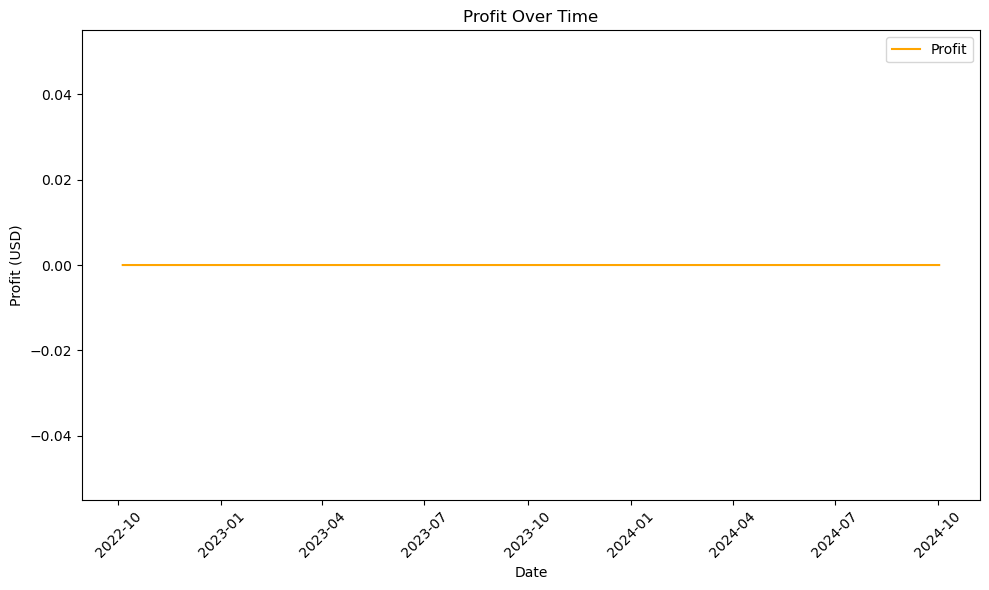

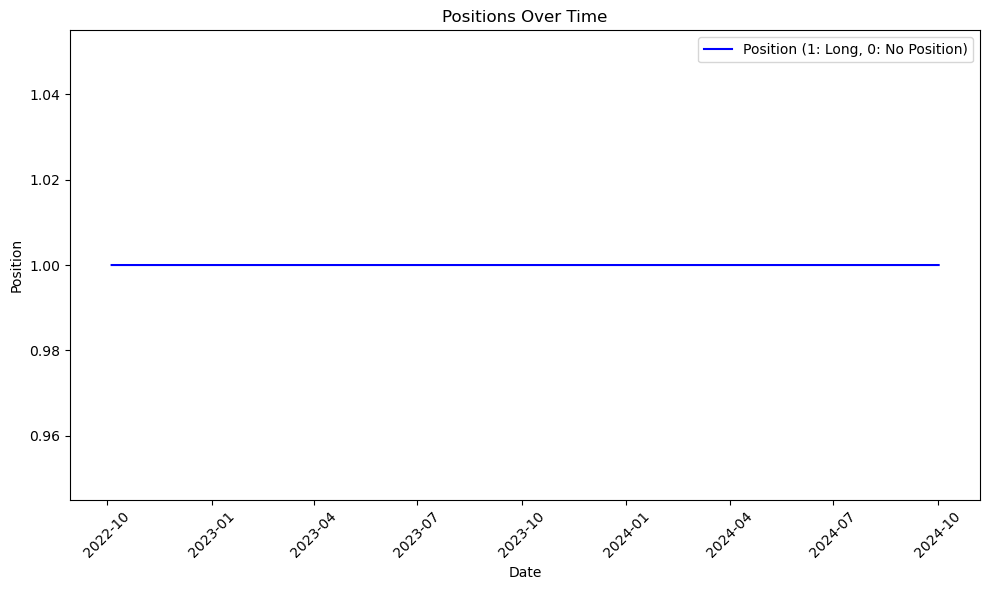

In [7]:
# ============================================================================
# 1. RUNNING THE TRAINED MODEL ON SAME DATA (EURUSD H1 - Oct 2022 to Oct 2024)
# ============================================================================

# Load the trained PPO model
model = PPO.load("100000_timestamps_PPO")

# Initialize lists for tracking data
profits = []
positions = []
dates = []  # This will hold actual dates from the market data

# Initialize variables for tracking profit and positions
current_profit = 0
entry_price = 0  # Price at which the position was entered

# Exclude non-feature columns (e.g., 'Date', 'DateTime')
feature_columns = [
    'Open', 'High', 'Low', 'Close', 'TickVol', 'Spread',
    'Hour_sin', 'Hour_cos', 'SMA_10', 'SMA_50',
    'EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_Signal',
    'MACD_Diff', 'Bollinger_High', 'Bollinger_Low',
    'Bollinger_Middle', 'ATR', 'OBV', 'Ichimoku_A',
    'Ichimoku_B', 'CCI', 'VWAP'
]

df_features = df[feature_columns]  # Select only the relevant 25 feature columns

# ==================
# 2. EVALUATION LOOP
# ==================

# Global variables to simulate the trading environment
account_balance = 10000  # Initial balance in USD
position_size = 0        # Size of the current position (in asset units)
current_position = 0     # Current position: 0 = no position, 1 = long

def execute_long_trade(current_price):
    """
    Execute a long trade (buy).
    """
    global account_balance, position_size, current_position, entry_price

    if account_balance > 0:
        position_size = account_balance / current_price
        account_balance = 0
        current_position = 1
        entry_price = current_price
        print(f"Bought {position_size:.4f} units at {current_price:.4f}")
    else:
        print("Insufficient balance to execute long trade.")

def close_long_trade(current_price):
    """
    Close a long trade (sell).
    """
    global account_balance, position_size, current_position, current_profit

    if current_position == 1:
        sale_amount = position_size * current_price
        trade_profit = sale_amount - (position_size * entry_price)
        account_balance = sale_amount
        current_profit += trade_profit
        position_size = 0
        current_position = 0
        print(f"Sold long position at {current_price:.4f}, account balance: {account_balance:.2f}")
    else:
        print("No long position to close.")

def log_results(profit, dates):
    """
    Log the results of the evaluation.
    """
    global account_balance

    # Count the number of trades (every time a position changes from 0 to 1 (buy) or from 1 to 0 (sell))
    num_trades = 0
    for i in range(1, len(positions)):
        if positions[i] != positions[i - 1]:  # Change in position
            num_trades += 1

    print(f"Evaluation complete.")
    print(f"Final Account Balance: {account_balance:.2f}")
    print(f"Total Profit: {profit:.2f}")
    print(f"Number of Trades (Buy/Sell Pairs): {num_trades // 2}")  # Each buy/sell pair is a trade
    print(f"Position Size at End: {position_size:.4f} units")


# Evaluation Loop
for i in range(len(df_features)):
    # Get the current market state (features) for this date
    current_state = df_features.iloc[i].values.reshape(1, -1)

    # Use the model to predict the action
    action, _states = model.predict(current_state, deterministic=True)

    # Access the current close price
    current_price = df['Close'].iloc[i]

    # Execute actions based on the predicted action
    if action == 1:
        if current_position == 0:
            # Execute a long trade (buy)
            execute_long_trade(current_price)
            positions.append(1)  # Long position
        else:
            # Already in a long position; hold
            positions.append(1)
    elif action == 2:
        if current_position == 1:
            # Close the long position
            close_long_trade(current_price)
            positions.append(0)
        else:
            # Not in a position; hold
            positions.append(0)
    else:
        # Hold (do nothing)
        positions.append(current_position)

    # Log the current profit and date
    profits.append(current_profit)
    dates.append(df['Date'].iloc[i])  # Append the actual date

# Log the results
log_results(current_profit, dates)

# ===================
# 3. PLOTTING RESULTS
# ===================

# Plot Profit Over Time
plt.figure(figsize=(10, 6))
plt.plot(dates, profits, label='Profit', color='orange')
plt.xlabel('Date')
plt.ylabel('Profit (USD)')
plt.title('Profit Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Positions Over Time
plt.figure(figsize=(10, 6))
plt.plot(dates, positions, label='Position (1: Long, 0: No Position)', color='blue')
plt.xlabel('Date')
plt.ylabel('Position')
plt.title('Positions Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()